# Upload Libraries

In [ ]:
!pip install -q streamlit

In [ ]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Load and Prepare Dataset

In [2]:
#import the dataset:
Dataset = tf.keras.utils.image_dataset_from_directory(r"D:\Coures\Machinelearning\epsilon_ai\Deep_Learning\final\FF\Fast Food Classification V2",
                                                      image_size=(128, 128), batch_size=32)

Found 20000 files belonging to 3 classes.


In [3]:
from PIL import Image
import os

root_dir = "D:\Coures\Machinelearning\epsilon_ai\Deep_Learning\final\FF\Fast Food Classification V2"
weird_files = []

for folder, _, files in os.walk(root_dir):
    for file in files:
        file_path = os.path.join(folder, file)
        try:
            with Image.open(file_path) as img:
                if img.format not in ["JPEG", "PNG", "BMP", "GIF"]:
                    weird_files.append((file_path, img.format))
        except Exception:
            weird_files.append((file_path, "Unreadable"))

print(f"Found {len(weird_files)} unusual image formats.\n")
for f, fmt in weird_files[:20]:
    print(f" - {f}  (Detected format: {fmt})")


Found 0 unusual image formats.



In [4]:
import os

root_dir = "D:\Coures\Machinelearning\epsilon_ai\Deep_Learning\final\FF\Fast Food Classification V2"
valid_ext = [".jpg", ".jpeg", ".png", ".bmp", ".gif"]

for folder, _, files in os.walk(root_dir):
    for file in files:
        file_path = os.path.join(folder, file)
        try:
            with Image.open(file_path) as img:
                if img.format not in ["JPEG", "PNG", "BMP", "GIF"]:
                    os.remove(file_path)
                    print(f"🗑️ Deleted {file_path} (format: {img.format})")
        except:
            os.remove(file_path)
            print(f"🗑️ Deleted unreadable file: {file_path}")


### check dataset labels (to see if it is sparse or categorical)

In [5]:
images, labels = next(iter(Dataset))

In [6]:
print("Labels shape:", labels.shape)
print("Labels dtype:", labels.dtype)
print("First 5 labels:\n", labels[:30].numpy())

Labels shape: (32,)
Labels dtype: <dtype: 'int32'>
First 5 labels:
 [2 2 1 1 2 1 1 1 1 1 2 0 2 2 1 1 1 2 1 1 1 1 1 1 1 0 1 1 2 0]


### Preview a sample from dataset

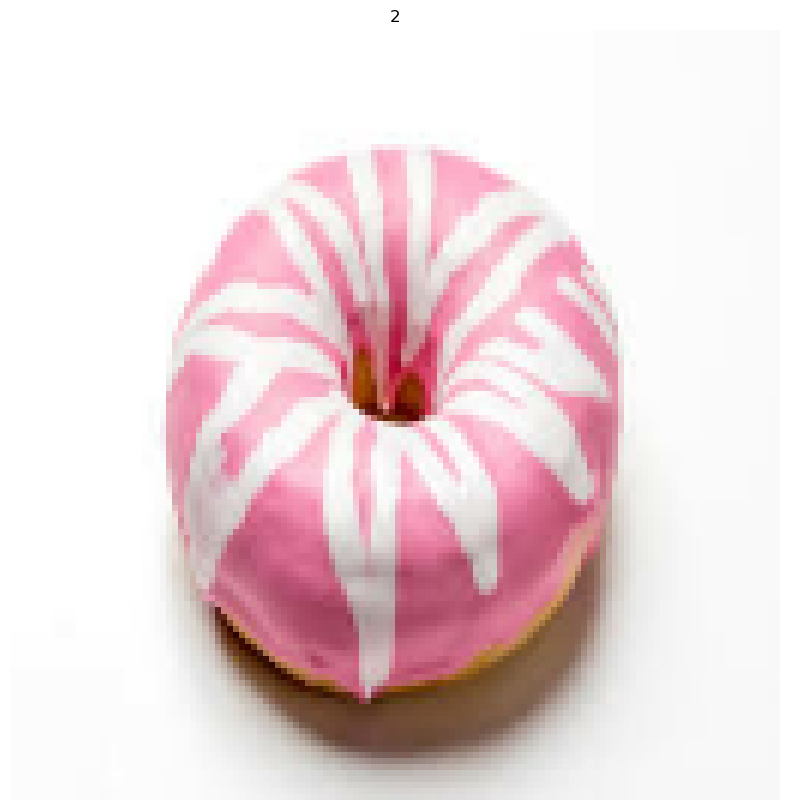

In [7]:
plt.figure(figsize=(10,10))
img = images[0].numpy().astype("uint8")
plt.imshow(img)
plt.title(int(labels[0]))
plt.axis("off")
plt.show()

### Split Dataset (train , test , validation)

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory( r"D:\Coures\Machinelearning\epsilon_ai\Deep_Learning\final\FF\Fast Food Classification V2\Train",
                                                      labels='inferred',
                                                      label_mode='int',
                                                      image_size=(128, 128),
                                                      batch_size=32,
                                                      shuffle=True,
                                                      seed=42)

val_ds = tf.keras.utils.image_dataset_from_directory(r"D:\Coures\Machinelearning\epsilon_ai\Deep_Learning\final\FF\Fast Food Classification V2\Valid",
                                                     labels='inferred',
                                                     label_mode='int',
                                                     image_size=(128, 128),
                                                     shuffle=True,
                                                     seed=42)


test_ds = tf.keras.utils.image_dataset_from_directory(r"D:\Coures\Machinelearning\epsilon_ai\Deep_Learning\final\FF\Fast Food Classification V2\Test",
                                                      labels='inferred',
                                                      label_mode='int',
                                                      image_size=(128, 128),
                                                      shuffle=True
                                                      )

Found 15000 files belonging to 10 classes.
Found 3500 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.


In [ ]:
# Collect the class names
class_names = sorted(os.listdir(r'D:\Coures\Machinelearning\epsilon_ai\Deep_Learning\final\FF\Fast Food Classification V2\Train'))
n_classes = len(class_names)

# Print
print("No. Classes : {}".format(n_classes))
print("Classes     : {}".format(class_names))

No. Classes : 10
Classes     : ['Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito']


In [ ]:
# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 128, 128, 3)
(32,)


# CNN Model

In [ ]:

#### Input_layer
img_input_ = Input(shape=(128, 128, 3))

# Augmentation and rescaling for training + validation
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.2,  
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# rescale test set
test_datagen = ImageDataGenerator(rescale=1/255.0)

# Training set:
train_generator = train_datagen.flow_from_directory(
    r"D:\Coures\Machinelearning\epsilon_ai\Deep_Learning\final\FF\Fast Food Classification V2\Train",
    target_size=(128,128),
    batch_size=32,
    class_mode='sparse',
    shuffle=True,
    seed=42
)

# Validation set: 
val_generator = train_datagen.flow_from_directory(
    r"D:\Coures\Machinelearning\epsilon_ai\Deep_Learning\final\FF\Fast Food Classification V2\Valid",
    target_size=(128,128),
    batch_size=32,
    class_mode='sparse',
    shuffle=True,
    seed=42
)

# Testing set:
test_generator = test_datagen.flow_from_directory(
    r"D:\Coures\Machinelearning\epsilon_ai\Deep_Learning\final\FF\Fast Food Classification V2\Test",
    target_size=(128,128),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

#### Rescaling after augmentation
#input_ = Rescaling(1/255.0)(img_) # rescaling within the model it's self / or use: BatchNormalization()(img_input_)

#### Conv Layer 1
hidden = Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(img_input_)
hidden = BatchNormalization()(hidden)
hidden = ReLU()(hidden)
#hidden = Dropout(0.1)(hidden) # to avoid overfitting

hidden = Conv2D(32, kernel_size=3, kernel_initializer='he_normal')(hidden)
hidden = BatchNormalization()(hidden)
hidden = ReLU()(hidden)
#hidden = Dropout(0.1)(hidden) # to avoid overfitting

hidden = MaxPool2D()(hidden)

#### Conv Layer 2
hidden = Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(hidden)
hidden = BatchNormalization()(hidden)
hidden = ReLU()(hidden)
#hidden = Dropout(0.1)(hidden) # to avoid overfitting

hidden = Conv2D(64, kernel_size=3, kernel_initializer='he_normal')(hidden)
hidden = BatchNormalization()(hidden)
hidden = ReLU()(hidden)
#hidden = Dropout(0.1)(hidden) # to avoid

hidden = MaxPool2D()(hidden)

#### Conv Layer 3
hidden = Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(hidden)
hidden = BatchNormalization()(hidden)
hidden = ReLU()(hidden)
#hidden = Dropout(0.1)(hidden) # to avoid overfitting

hidden = Conv2D(128, kernel_size=3, kernel_initializer='he_normal')(hidden)
hidden = BatchNormalization()(hidden)
hidden = ReLU()(hidden)
#hidden = Dropout(0.1)(hidden) # to avoid overfitting

hidden = MaxPool2D()(hidden)

#hidden = GlobalAveragePooling2D()(hidden)

hidden = Flatten()(hidden)

#### Dense Layer 1
hidden = Dense(128, kernel_initializer='he_normal')(hidden)
hidden = BatchNormalization()(hidden)
hidden = ReLU()(hidden)
#hidden = Dropout(0.1)(hidden) # to avoid overfitting

#### Output_Layer
output = Dense(10, activation='softmax', kernel_initializer='glorot_normal')(hidden)

CNN_model = Model(inputs=[img_input_], outputs=[output])
CNN_model.summary()

Found 15000 images belonging to 10 classes.
Found 3500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             

 Total params: 3,501,994 (13.36 MB)

 Trainable params: 3,500,842 (13.35 MB)

 Non-trainable params: 1,152 (4.50 KB)

### Compile Model

In [ ]:
optimizer = Adam(learning_rate = 0.001)
CNN_model.compile(optimizer=optimizer , loss='sparse_categorical_crossentropy',metrics=['accuracy'])

### Train Model

In [ ]:
history1 = CNN_model.fit(
    train_generator,
    validation_data = val_ds,
    epochs=30)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1729s 4s/step - accuracy: 0.3920 - loss: 1.7775 - val_accuracy: 0.4106 - val_loss: 1.8060
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1564s 3s/step - accuracy: 0.5272 - loss: 1.4124 - val_accuracy: 0.4600 - val_loss: 1.6511
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1120s 2s/step - accuracy: 0.5907 - loss: 1.2403 - val_accuracy: 0.3663 - val_loss: 2.1689
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1117s 2s/step - accuracy: 0.6293 - loss: 1.1274 - val_accuracy: 0.5849 - val_loss: 1.3112
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1119s 2s/step - accuracy: 0.6610 - loss: 1.0286 - val_accuracy: 0.4220 - val_loss: 2.1183
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1072s 2s/step - accuracy: 0.6875 - loss: 0.9532 - val_accuracy: 0.4551 - val_loss: 1.8459
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1079s 2s/step - accuracy: 0.7009 - loss: 0.8954 - val_accuracy: 0.4214 - val_loss: 2.0509
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1083s 2s/step - accuracy: 0.7299 - loss: 0.8308 - 

In [ ]:
def plot_loss_acc(history1, model_name='model_1'):
    plt.title(f"Loss - {model_name}")
    plt.plot(history1.history['loss'], c='red', label='train_loss')
    plt.plot(history1.history['val_loss'], c='green', label='valid_loss')
    plt.legend()
    plt.show()

    plt.title(f"Accuracy - {model_name}")
    plt.plot(history1.history['accuracy'], c='red', label='train_accuracy')
    plt.plot(history1.history['val_accuracy'], c='green', label='valid_accuracy')
    plt.legend()
    plt.show()

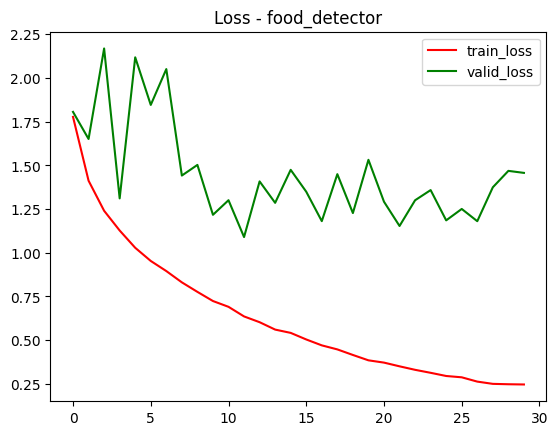

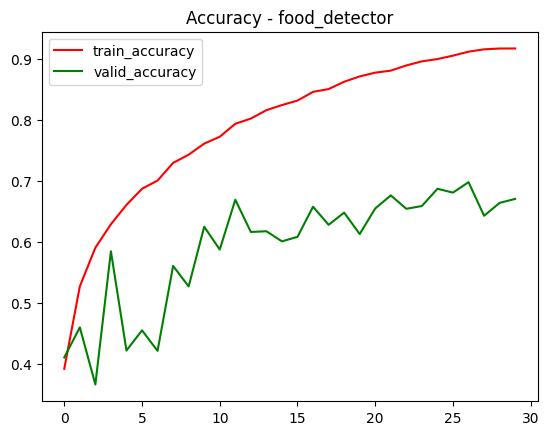

In [25]:
plot_loss_acc(history1, model_name='food_detector')

In [ ]:
CNN_model.evaluate(test_ds)

d:\Programes\Anaconda\envs\miky\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 709ms/step - accuracy: 0.6920 - loss: 1.3263


[1.3262739181518555, 0.6919999718666077]

### Save Model

In [ ]:
CNN_model.save("custom_cnn_fastfood.h5")

# Model Finetunning

In [2]:
# CONFIGURATION
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
DATASET_DIR = r"D:\Coures\Machinelearning\epsilon_ai\Deep_Learning\final\FF\Fast Food Classification V2"  
NUM_CLASSES = 10     
img_input_ = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

#### Augmentation on the fly
img_ = RandomFlip("horizontal")(img_input_)
img_ = RandomRotation(0.1)(img_)
img_ = RandomZoom(0.1)(img_)
img_ = RandomContrast(0.1)(img_)
img_ = RandomTranslation(0.1, 0.1)(img_)
img_ = Rescaling(1./255)(img_)                   

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory( r"D:\Coures\Machinelearning\epsilon_ai\Deep_Learning\final\FF\Fast Food Classification V2\Train",
                                                      labels='inferred',
                                                      label_mode='int',
                                                      image_size=(IMG_SIZE, IMG_SIZE),
                                                      batch_size=32,
                                                      shuffle=True,
                                                      seed=42)

val_ds = tf.keras.utils.image_dataset_from_directory(r"D:\Coures\Machinelearning\epsilon_ai\Deep_Learning\final\FF\Fast Food Classification V2\Valid",
                                                     labels='inferred',
                                                     label_mode='int',
                                                     image_size=(IMG_SIZE, IMG_SIZE),
                                                     shuffle=True,
                                                     seed=42)


test_ds = tf.keras.utils.image_dataset_from_directory(r"D:\Coures\Machinelearning\epsilon_ai\Deep_Learning\final\FF\Fast Food Classification V2\Test",
                                                      labels='inferred',
                                                      label_mode='int',
                                                      image_size=(IMG_SIZE, IMG_SIZE),
                                                      shuffle=True
                                                      )

Found 14999 files belonging to 10 classes.
Found 3500 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.


### Best Model Architecture

In [ ]:
# Load Model

base_model = DenseNet201(
    include_top=False,
    weights="imagenet",          
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze most layers

for layer in base_model.layers[:-30]:
    layer.trainable = False

# Dense Layers

dense = GlobalAveragePooling2D()(base_model.output)
dense = Dropout(0.3)(dense)
dense = Dense(256, activation="relu")(dense)
dense = Dropout(0.2)(dense)
output = Dense(NUM_CLASSES, activation="softmax")(dense)

#Output Layers

model = Model(inputs=base_model.input, outputs=output)

#Summary

model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,816,330 (71.78 MB)

 Trainable params: 1,603,466 (6.12 MB)

 Non-trainable params: 17,212,864 (65.66 MB)

### Compile Model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

### Callback

In [ ]:
callbacks = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy')

### Train Model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

d:\Programes\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 26/375 ━━━━━━━━━━━━━━━━━━━━ 34:13 6s/step - accuracy: 0.9268 - loss: 0.2173

d:\Programes\Anaconda\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


375/375 ━━━━━━━━━━━━━━━━━━━━ 2798s 7s/step - accuracy: 0.9288 - loss: 0.2272 - val_accuracy: 0.8686 - val_loss: 0.4462
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2177s 6s/step - accuracy: 0.9357 - loss: 0.2033 - val_accuracy: 0.8800 - val_loss: 0.4351
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2190s 6s/step - accuracy: 0.9415 - loss: 0.1866 - val_accuracy: 0.8800 - val_loss: 0.4323
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2182s 6s/step - accuracy: 0.9413 - loss: 0.1811 - val_accuracy: 0.8814 - val_loss: 0.4310
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2167s 6s/step - accuracy: 0.9480 - loss: 0.1656 - val_accuracy: 0.8771 - val_loss: 0.4351
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2164s 6s/step - accuracy: 0.9513 - loss: 0.1580 - val_accuracy: 0.8914 - val_loss: 0.4198
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2195s 6s/step - accuracy: 0.9539 - loss: 0.1450 - val_accuracy: 0.8843 - val_loss: 0.4587
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2176s 6s/step - accuracy: 0.9506 - loss: 0.1511 - val_accurac

In [ ]:
model.evaluate(val_ds)

Found 1500 files belonging to 10 classes.


d:\Programes\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - accuracy: 0.8900 - loss: 0.4438


[0.4437505304813385, 0.8899999856948853]

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

d:\Programes\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 269s 6s/step - accuracy: 0.8760 - loss: 0.4706


### Save Final Model

In [ ]:
model.save("final_fastfood_DenseNet.h5")

#### Model Evaluation (on validation)

* a) Confusion Matrix

* b) Full Classification Report

* c) Highest error class and highest error instance

#### a) Confusion Matrix

In [ ]:
y_valid_probs = model.predict(val_ds)
y_valid_preds = tf.math.argmax(y_valid_probs, axis=1)
y_valid_true = tf.concat([y for x, y in val_ds], axis=0)

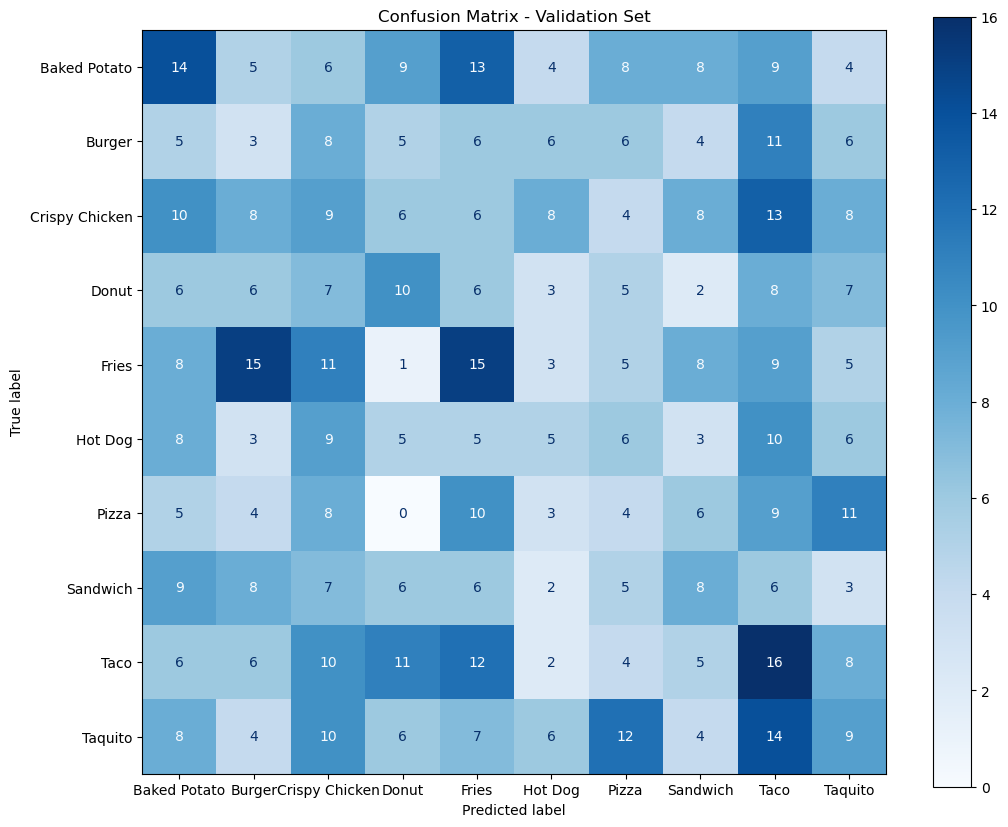

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ConfusionMatrixDisplay.from_predictions(
    y_valid_true,
    y_valid_preds,
    display_labels=class_names,
    cmap="Blues",
    ax=ax
)

plt.show()

#### b) Full Classification Report


In [ ]:
print(classification_report(y_valid_true, y_valid_preds))

              precision    recall  f1-score   support

           0       0.18      0.17      0.18        80
           1       0.05      0.05      0.05        60
           2       0.11      0.11      0.11        80
           3       0.17      0.17      0.17        60
           4       0.17      0.19      0.18        80
           5       0.12      0.08      0.10        60
           6       0.07      0.07      0.07        60
           7       0.14      0.13      0.14        60
           8       0.15      0.20      0.17        80
           9       0.13      0.11      0.12        80

    accuracy                           0.13       700
   macro avg       0.13      0.13      0.13       700
weighted avg       0.13      0.13      0.13       700



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


C:\Users\Koky\AppData\Local\Temp\ipykernel_980\3521881997.py:44: UserWarning: Glyph 127828 (\N{HAMBURGER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


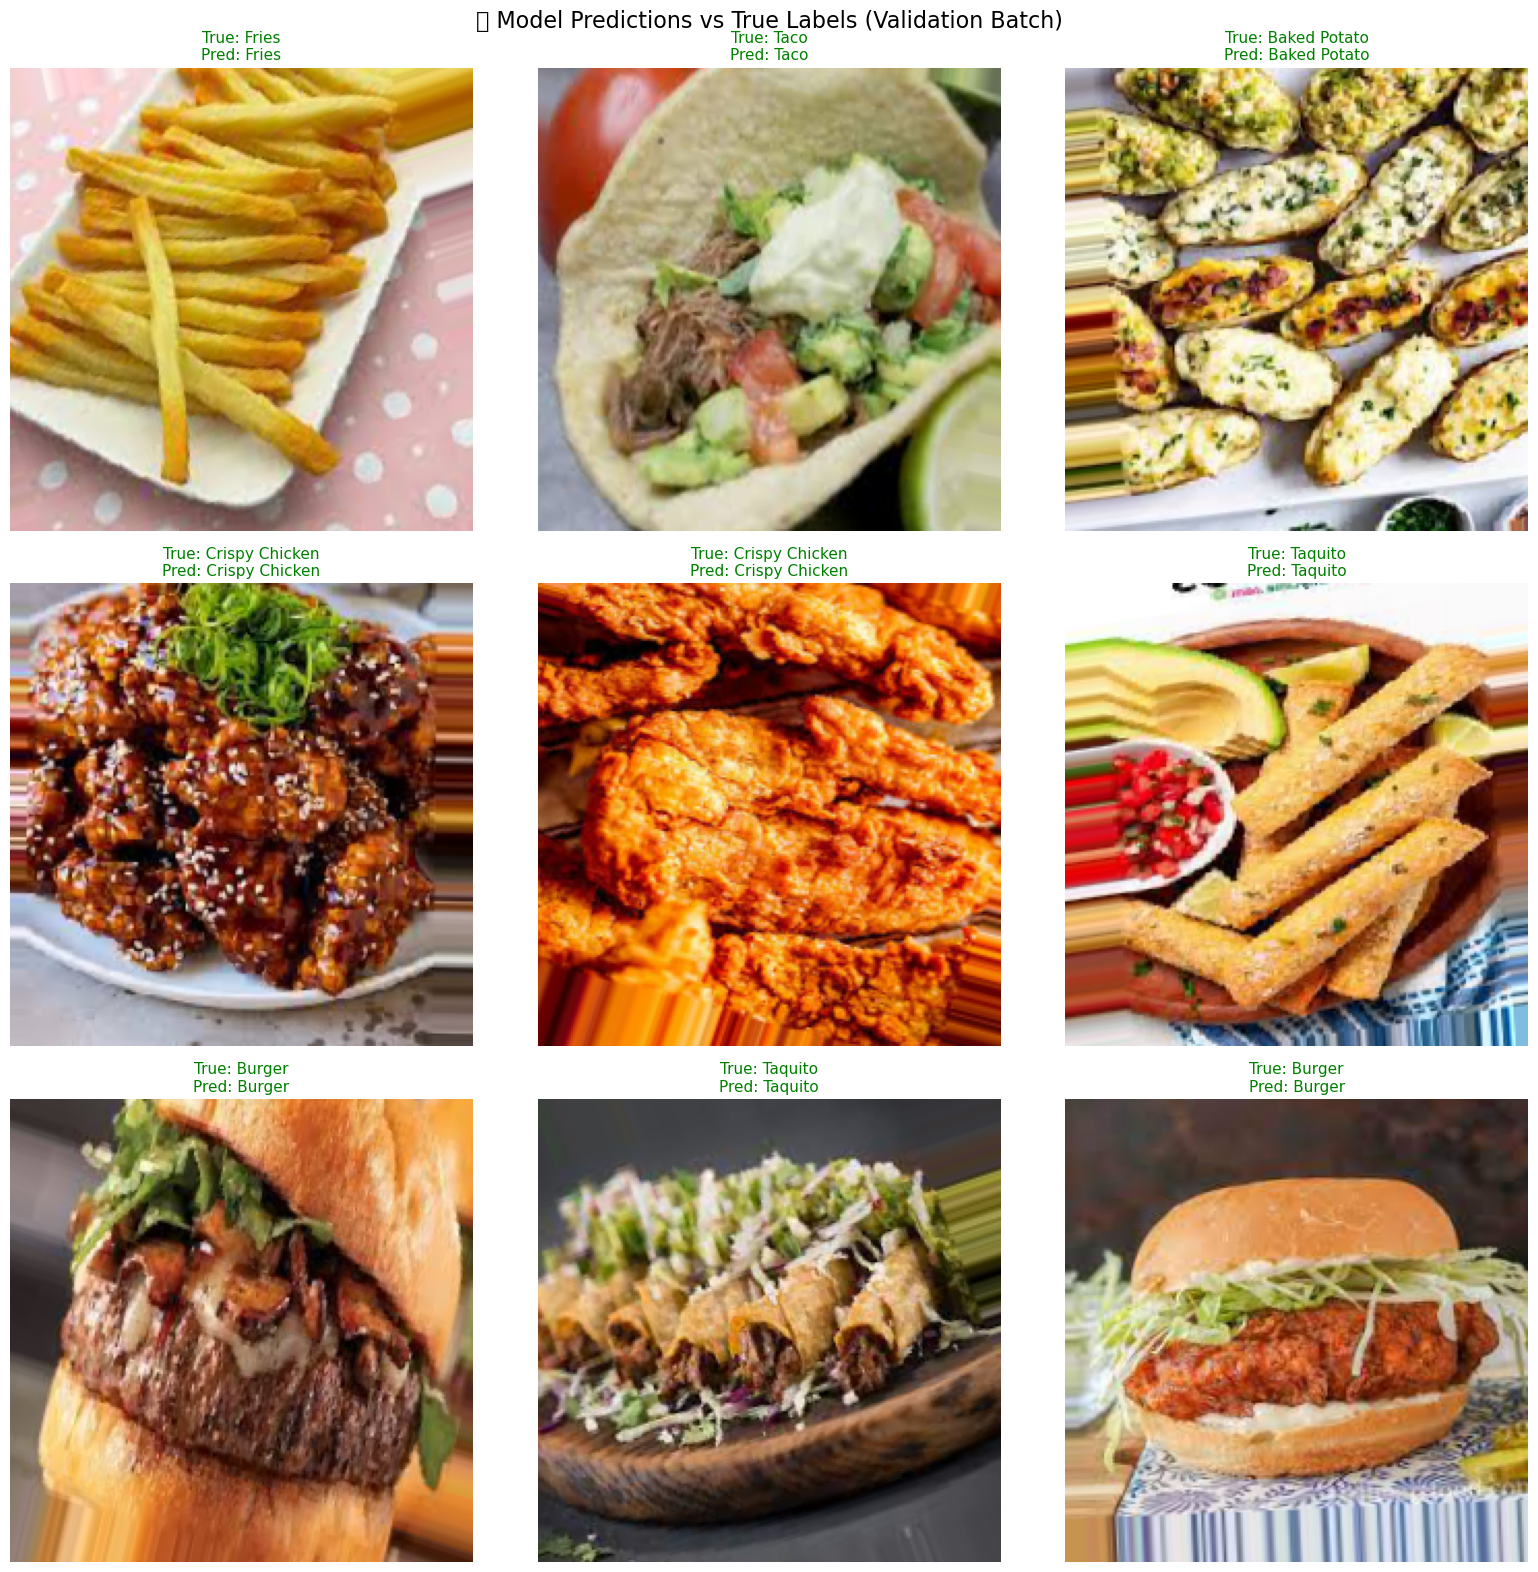

In [ ]:
images, labels = next(iter(val_ds))

images = images.numpy()
labels = labels.numpy()

true_classes = labels


preds = model.predict(images)
pred_classes = np.argmax(preds, axis=1)

class_names = class_names  

plt.figure(figsize=(16, 16))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    
    img = images[i]
    if np.max(img) <= 1:
        img = img * 255
    plt.imshow(img.astype("uint8"))
    
    true_label = class_names[int(true_classes[i])]
    pred_label = class_names[int(pred_classes[i])]
    
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=11)
    plt.axis("off")

plt.suptitle("🍔 Model Predictions vs True Labels (Validation Data)", fontsize=16)
plt.tight_layout()
plt.show()


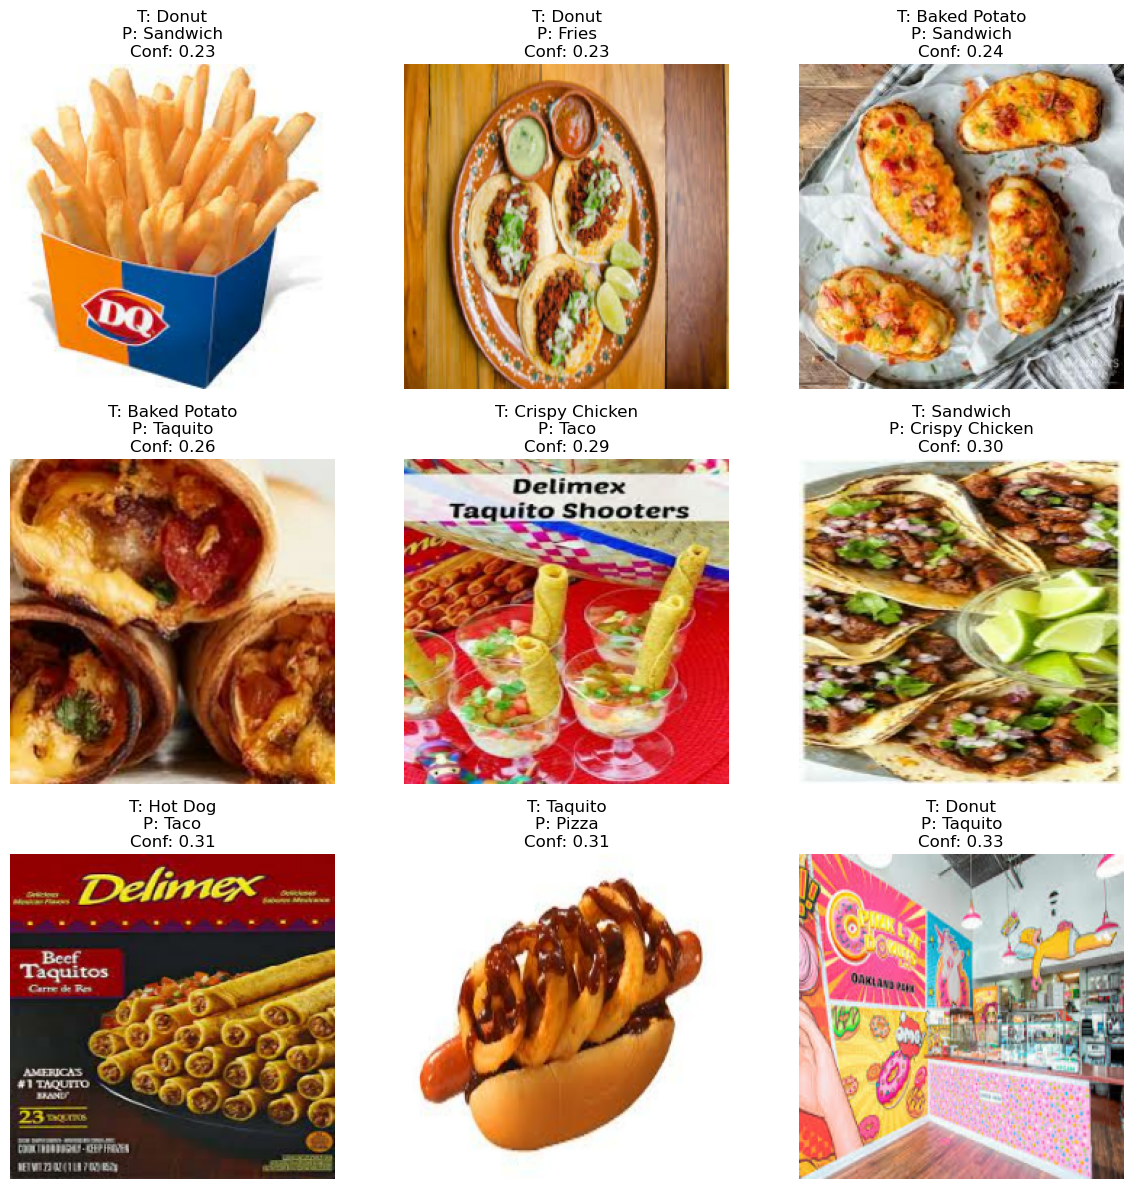

In [ ]:


# Get probability of the predicted class for each sample
row_indices = np.arange(len(y_valid_preds))
pred_class_probs = y_valid_probs[row_indices, y_valid_preds]

# Identify misclassified indices
misclassified_idx = tf.where(y_valid_true != tf.cast(y_valid_preds, dtype=tf.int32))[:, 0]

# Sort misclassified samples by model confidence (low → high)
misclassified_probs = tf.gather(pred_class_probs, misclassified_idx)
sorted_order = tf.argsort(misclassified_probs, direction="ASCENDING")
worst_indices = tf.gather(misclassified_idx, sorted_order)

# Pick worst 9
worst_9 = worst_indices[:9].numpy()

# ---- Collect validation set images & labels ----
val_images = []
val_labels = []
for x, y in val_ds.unbatch():
    val_images.append(x)
    val_labels.append(y)

val_images = tf.stack(val_images)   # shape: (N, H, W, C)
val_labels = tf.stack(val_labels)   # shape: (N,)

# ---- Display ----
plt.figure(figsize=(12, 12))
for i, idx in enumerate(worst_9):
    img = val_images[idx]
    label = val_labels[idx]

    plt.subplot(3, 3, i+1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.axis("off")
    plt.title(
        f"T: {class_names[y_valid_true[idx]]}\n"
        f"P: {class_names[y_valid_preds[idx]]}\n"
        f"Conf: {pred_class_probs[idx]:.2f}"
    )

plt.tight_layout()
plt.show()